### This notebook is stale - master is on WML

Git Repo: https://github.ibm.com/wiotp/monitoring-dashboard


In [132]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [171]:
#### Code for exporting git defects as csv list
"""
Exports Issues from a specified repository to a CSV file

Uses basic authentication (Github username + password) to retrieve Issues
from a repository that username has access to. Supports Github API v3.
"""
import csv
import requests


GITHUB_USER = 'markus_mueller@de.ibm.com'
GITHUB_PASSWORD = ''
REPO = 'wiotp/monitoring-dashboard'  # format is username/repo
# # https://github.ibm.com/wdp-chs/tracker/issues
AUTH = (GITHUB_USER, GITHUB_PASSWORD)


# 
# #Update your personal API token here
GITHUB_TOKEN = 'ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab'
headers = {'Authorization': 'token %s' % GITHUB_TOKEN }


ISSUES_FOR_REPO_URL = 'https://github.ibm.com/api/v3/repos/%s/issues' % REPO

# Update your filter here.  See https://developer.github.com/v3/issues/#list-issues-for-a-repository
# Note that filtering is powerful and there are lots of things available. Also that issues and PRs
# arrive in the same results set
params_payload = {'filter' : 'all', 'state' : 'open', 'type': 'issue' }

# # Update your filter here.  Filter is who owns the issue.  State is open, closed, or all.
params_payload = {'is' : 'issue','filter' : 'all', 'state':'closed' }
params_payload = {'is' : 'issue', 'state':'open' }



"""

Exports Issues from a specified repository to a CSV file
Uses basic authentication (Github username + password) or token to retrieve Issues
from a repository that username has access to. Supports Github API v3.
"""


def write_issues(response, csvout):
    "output a list of issues to csv"
    print ("  : Writing %s issues" % len(response.json()))
        
    for issue in response.json():
        # print (issue)
        labels = issue['labels']
        created_at = issue['created_at']
        if created_at is None:
            created_at_ = '2010-01-01T00:00:00Z'
        created_at = dt.datetime.strptime(created_at, "%Y-%m-%dT%H:%M:%SZ")

        updated_at = issue['updated_at']
        if updated_at is not None:
            updated_at = dt.datetime.strptime(updated_at, "%Y-%m-%dT%H:%M:%SZ")
        
        closed_at = issue['closed_at']
        if closed_at is not None:
            closed_at = dt.datetime.strptime(closed_at, "%Y-%m-%dT%H:%M:%SZ")

        label_string = ''
        componentLabel = ''
        label_list = []
        for label in labels:
              label_list.append(str(label['name']).strip().strip().lstrip().rstrip())
                        
        for label in label_list:
            componentLabel = ''
            if label.startswith('Component') or label.startswith('Scrum') or label.startswith('Squad:'):
                label = label.strip()
                componentLabel = label.split(':')[1]
            theme = ''
            if label.find('Theme') >= 0:
                theme = label
            blocked = ''
            if label.startswith('blocked'):
                blocked = 'YES'
            issueType = 'Issue'
            if label.startswith('Epic'):
                issueType = 'Epic'
            elif label.startswith('bug'):
                issueType = 'Bug'
            elif label.startswith('Enhancement'):
                issueType = 'Enhancement'
        #print(label, componentLabel, theme, blocked)
        #print("componentLabel=%s" % componentLabel)
        csvout.writerow([issue['number'], issue['title'], # issue['body'].encode('utf-8'),
                        created_at, updated_at, closed_at, issueType, componentLabel,
                        theme, blocked]) # str(label_list).encode('utf-8')])


def get_issues(url):
    kwargs = {
        'headers': {
            'Content-Type': 'application/vnd.github.v3.raw+json',
            'User-Agent': 'Padkrish issue exporter'
        },
        'params': params_payload
    }
    if GITHUB_TOKEN != '':
        kwargs['headers']['Authorization'] = 'token %s' % GITHUB_TOKEN
    else:
        kwargs['auth'] = (GITHUB_USER, GITHUB_PASSWORD)

    print ("GET %s" % url)
    resp = requests.get(url, **kwargs)
    print ("  : => %s" % resp.status_code)
    
    # import ipdb; ipdb.set_trace()
    if resp.status_code != 200:
        raise Exception(resp.status_code)

    return resp


def next_page(response):
    #more pages? examine the 'link' header returned
    if 'link' in response.headers:
        pages = dict(
            [(rel[6:-1], url[url.index('<')+1:-1]) for url, rel in
                [link.split(';') for link in
                    response.headers['link'].split(',')]])
        # import ipdb; ipdb.set_trace()
        if 'last' in pages and 'next' in pages:
            return pages['next']
    return None


def process(csvout, url=ISSUES_FOR_REPO_URL):
    resp = get_issues(url)
    write_issues(resp, csvout)
    next_ = next_page(resp)
    if next_ is not None:
        process(csvout, next_)


csvfilename = '%s-defects-closed-v1.csv' % (REPO.replace('/', '-'))
csvfile = open(csvfilename, 'w', newline='')
csvout = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
csvout.writerow(( 'Title', 'Created', 'Updated', 'Closed', 'Type','Component', 'Theme', 'Blocked'))
process(csvout)
csvfile.close()


GET https://github.ibm.com/api/v3/repos/wiotp/monitoring-dashboard/issues
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=open&page=2
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=open&page=3
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=open&page=4
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=open&page=5
  : => 200
  : Writing 19 issues


In [174]:
defects_df = pd.read_csv('./wiotp-monitoring-dashboard-defects-closed-v1.csv') # parse_dates=['Created'])

## Remove the encoding prefix string
df=defects_df.replace('b\'','',regex=True).astype(object)
df=df.replace('b\"','',regex=True).astype(object)
df['Created'] = pd.to_datetime(df['Created'])
df.head()


,Title,Created,Updated,Closed,Type,Component,Theme,Blocked
890,Configurable action to launch from dashboard,2020-03-26 13:22:51,2020-03-26 13:34:39,NaN,Issue,Monitoring,NaN,NaN
889,Xaxis of TimeSeries chart doesn't show all tim...,2020-03-25 20:58:50,2020-03-26 13:30:25,NaN,Bug,NaN,NaN,NaN
886,Update IBMid Cloud Identity cert as our old on...,2020-03-24 15:06:45,2020-03-26 14:08:43,NaN,Issue,NaN,NaN,NaN
885,Anomaly model and alert instability,2020-03-24 10:59:07,2020-03-26 15:29:20,NaN,Bug,NaN,NaN,NaN
884,Hierarchy management using a Taxonomy Section,2020-03-23 10:19:26,2020-03-23 10:19:49,NaN,Issue,Monitoring,NaN,NaN


In [175]:
cnt = df.groupby('Type')['Title'].count()
print (cnt.index)

Index(['Bug', 'Epic', 'Issue'], dtype='object', name='Type')


Text(0.5, 1.0, 'Monitoring issues by type')

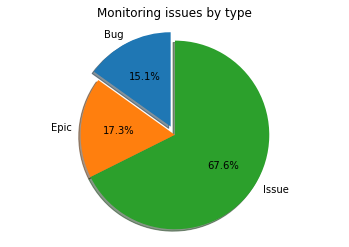

In [176]:
labels = cnt.index
sizes = cnt.values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=(0.1, 0, 0), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Monitoring issues by type')

#plt.show()

In [177]:
df['Created'] = pd.to_datetime(df['Created']) #, "%Y-%m-%d %H:%M:%S")


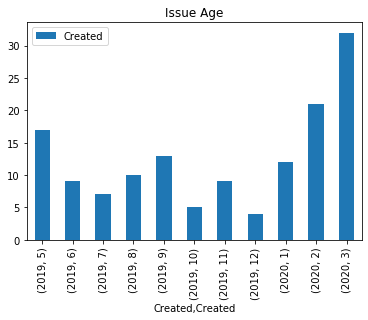

In [183]:
df_subset=df[['Created']].copy()
#df_subset['Created'].dt.year
df_subset.groupby([df_subset["Created"].dt.year, 
                   df_subset["Created"].dt.month]).count().plot(kind="bar", title='Issue Age')